/tmp/ipython-input-3516295092.py:63: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("topic", as_index=False).apply(lambda g: add_lags(g, N_LAGS), include_groups=True).reset_index(drop=True)


CV Mean Accuracy: 0.7301587301587302
CV Mean F1: 0.8224823090304166
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.237547
Test accuracy: 0.9130434782608695
Test F1: 0.95

Feature importances:
      feature  importance
     topic_id          73
         year          24
appear_mean_3          14
  appear_lag3          11
  appear_lag2           6
  appear_lag1           4

Saved historical plot to plots/historical_appearances.png

Top predicted topics for 2026 (by prob of appearing):
                                        topic  predicted_prob_appear  appear_2025  appear_2024  appear_2023
                              Acids and bases               0.966925            1            1            1
                        Atmospheric chemistry               0.966925            1            1            1
                             Atomic structure               0.966925            1            1            

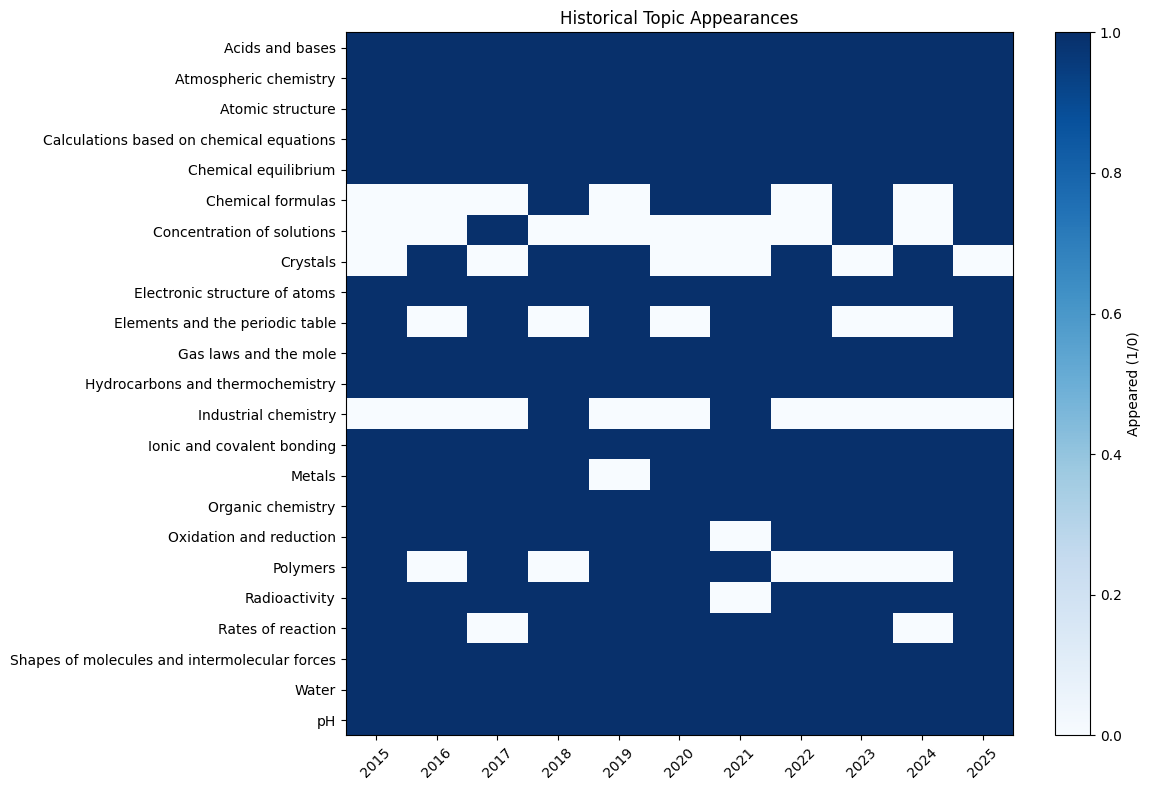

In [15]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier, early_stopping
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, f1_score
import re

# ---------- USER CONFIG ----------
CSV_PATH = "lc_topics_wide.csv"  # Local path; upload in Colab or use public URL below
CSV_URL = "https://docs.google.com/spreadsheets/d/1fZhDRbXM96enJFXnsP8eRJEVOcQ5agxaapMI9GfW_PQ/export?format=csv"  # If public, uncomment and use pd.read_csv(CSV_URL)
N_LAGS = 3
RANDOM_STATE = 42
THRESHOLD_PROB = 0.5
PLOT_DIR = "plots"
os.makedirs(PLOT_DIR, exist_ok=True)
# ---------------------------------

# Load and process
df_wide = pd.read_csv(CSV_URL)  # Or CSV_URL if public
df_wide = df_wide.rename(columns={df_wide.columns[0]: 'topic'})
year_cols = [col for col in df_wide.columns if col != 'topic' and 'deferred' not in col.lower()]
df_wide = df_wide[['topic'] + year_cols]

year_map = {}
for col in year_cols:
    year_str = re.search(r'\d{4}', col)
    if year_str:
        year_map[col] = int(year_str.group())
    else:
        raise ValueError(f"Invalid year header: {col}")

year_cols_sorted = sorted(year_cols, key=lambda c: year_map[c])
years = [year_map[c] for c in year_cols_sorted]

def compute_appear(cell):
    if pd.isna(cell) or not isinstance(cell, str) or cell.strip() == '':
        return 0
    return 1

for col in year_cols:
    df_wide[col] = df_wide[col].apply(compute_appear)

df = pd.melt(df_wide, id_vars=['topic'], value_vars=year_cols, var_name='year_col', value_name='appear')
df['year'] = df['year_col'].map(year_map)
df = df.drop(columns=['year_col'])
df = df[['year', 'topic', 'appear']].sort_values(['topic', 'year']).reset_index(drop=True)
df['year'] = df['year'].astype(int)

# Fill missing years with forward-fill then 0
df = df.set_index(['topic', 'year']).unstack().stack(future_stack=True).reset_index()
df['appear'] = df['appear'].ffill().fillna(0).astype(int)

def add_lags(g, n):
    g = g.sort_values("year").copy()
    for lag in range(1, n+1):
        g[f"appear_lag{lag}"] = g["appear"].shift(lag).fillna(0)
    g[f"appear_mean_{n}"] = g[[f"appear_lag{i}" for i in range(1, n+1)]].mean(axis=1)
    return g

df = df.groupby("topic", as_index=False).apply(lambda g: add_lags(g, N_LAGS), include_groups=True).reset_index(drop=True)

lag_cols = [f"appear_lag{i}" for i in range(1, N_LAGS+1)]
df_model = df.dropna(subset=lag_cols).reset_index(drop=True)

le = LabelEncoder()
df_model["topic_id"] = le.fit_transform(df_model["topic"])

features = lag_cols + [f"appear_mean_{N_LAGS}", "year", "topic_id"]
X = df_model[features].astype(float)
y = df_model["appear"].astype(int)

# Simplified time-series CV
tscv = TimeSeriesSplit(n_splits=3)  # Fewer splits for speed
cv_accuracies, cv_f1s = [], []

for train_idx, test_idx in tscv.split(X):
    X_train_cv, X_test_cv = X.iloc[train_idx], X.iloc[test_idx]
    y_train_cv, y_test_cv = y.iloc[train_idx], y.iloc[test_idx]
    model_cv = LGBMClassifier(random_state=RANDOM_STATE, n_estimators=100, verbose=-1)
    model_cv.fit(X_train_cv, y_train_cv)
    y_pred_cv = model_cv.predict(X_test_cv)
    cv_accuracies.append(accuracy_score(y_test_cv, y_pred_cv))
    cv_f1s.append(f1_score(y_test_cv, y_pred_cv, zero_division=0))

print("CV Mean Accuracy:", np.mean(cv_accuracies))
print("CV Mean F1:", np.mean(cv_f1s))

# Final model
last_year = df_model["year"].max()
train_mask = df_model["year"] < last_year
test_mask = df_model["year"] == last_year

X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]

model = LGBMClassifier(random_state=RANDOM_STATE, n_estimators=200, verbose=-1)
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], callbacks=[early_stopping(20)])
y_pred = model.predict(X_test)
print("Test accuracy:", accuracy_score(y_test, y_pred))
print("Test F1:", f1_score(y_test, y_pred, zero_division=0))

# Feature importances
fi = pd.DataFrame({"feature": features, "importance": model.feature_importances_}).sort_values("importance", ascending=False)
print("\nFeature importances:")
print(fi.to_string(index=False))

# Historical plot
pivot_df = df.pivot(index='topic', columns='year', values='appear')
plt.figure(figsize=(12, 8))
plt.imshow(pivot_df, cmap='Blues', aspect='auto')
plt.colorbar(label='Appeared (1/0)')
plt.xticks(range(len(pivot_df.columns)), pivot_df.columns, rotation=45)
plt.yticks(range(len(pivot_df.index)), pivot_df.index)
plt.title('Historical Topic Appearances')
plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, 'historical_appearances.png'))
print("\nSaved historical plot to plots/historical_appearances.png")

# Predict next year
next_year = last_year + 1
pred_rows = []
history_rows = []  # For adding history to results
for topic, g in df.sort_values("year").groupby("topic"):
    g = g.sort_values("year")
    last_vals = g["appear"].iloc[-N_LAGS:].values if len(g) >= N_LAGS else np.pad(g["appear"].values, (N_LAGS - len(g), 0), constant_values=0)[-N_LAGS:]
    row = {f"appear_lag{l+1}": last_vals[-(l+1)] for l in range(N_LAGS)}
    row[f"appear_mean_{N_LAGS}"] = np.mean(last_vals)
    row["year"] = next_year
    row["topic"] = topic
    row["topic_id"] = le.transform([topic])[0]
    pred_rows.append(row)
    # Add history
    last_years = g["year"].iloc[-3:].values if len(g) >= 3 else np.pad(g["year"].values, (3 - len(g), 0), constant_values=0)[-3:]
    last_appears = g["appear"].iloc[-3:].values if len(g) >= 3 else np.pad(g["appear"].values, (3 - len(g), 0), constant_values=0)[-3:]
    history_rows.append({
        "topic": topic,
        f"appear_{last_years[-1]}": last_appears[-1],
        f"appear_{last_years[-2]}": last_appears[-2],
        f"appear_{last_years[-3]}": last_appears[-3]
    })

X_future = pd.DataFrame(pred_rows)[features].astype(float)
preds_prob = model.predict_proba(X_future)[:, 1]

results = pd.DataFrame({"topic": [r["topic"] for r in pred_rows], "predicted_prob_appear": preds_prob})
history_df = pd.DataFrame(history_rows)
results = results.merge(history_df, on="topic")
results = results.sort_values("predicted_prob_appear", ascending=False).reset_index(drop=True)
print(f"\nTop predicted topics for {next_year} (by prob of appearing):")
print(results.head(15).to_string(index=False))

results["predicted_appear"] = (results["predicted_prob_appear"] >= THRESHOLD_PROB).astype(int)
print(f"\nTopics predicted to appear (threshold {THRESHOLD_PROB}):")
print(results[results["predicted_appear"]==1]["topic"].to_string(index=False))

# Save with history
results.to_csv("lc_predicted_2026.csv", index=False)
print("\nPredictions saved to lc_predicted_2026.csv (with last 3 years' history)")